In [1]:
import os
import json
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm

In [37]:
# Chemins
ROOT = Path("../data/SoccerNetGS")
SPLITS = ["train", "valid"]

# Initialisation
records = []
lines_by_frame = {}
for split in SPLITS:
    split_path = ROOT / split
    for clip in tqdm(os.listdir(split_path), desc=f"Parsing {split}"):
        if not clip.startswith("SNGS-"):
            continue
        label_path = split_path / clip / "Labels-GameState.json"  # avec un "s"

        if not label_path.exists():
            print(f"⚠️ Missing annotation file: {label_path}")
            continue

        with open(label_path) as f:
            label_data = json.load(f)

        if "annotations" not in label_data:
            print(f"❌ Pas d'annotations dans {label_path}")
            continue

        for ann in label_data["annotations"]:
            image_id = ann.get("image_id")
        
            # --- Objets dynamiques ---
            if ann.get("supercategory") == "object":
                category_id = ann.get("category_id")
                role = ann.get("attributes", {}).get("role")
                team = ann.get("attributes", {}).get("team")
                jersey = ann.get("attributes", {}).get("jersey")
                bbox_image = ann.get("bbox_image") or {}
                bbox_pitch = ann.get("bbox_pitch") or {}
        
                records.append({
                    "split": split,
                    "clip": clip,
                    "image_id": image_id,
                    "track_id": ann.get("track_id"),
                    "category_id": category_id,
                    "role": role,
                    "team": team,
                    "jersey": jersey,
                    "bbox_x": bbox_image.get("x"),
                    "bbox_y": bbox_image.get("y"),
                    "bbox_w": bbox_image.get("w"),
                    "bbox_h": bbox_image.get("h"),
                    "pitch_x": bbox_pitch.get("x_bottom_middle"),
                    "pitch_y": bbox_pitch.get("y_bottom_middle"),
                })
        
            # --- Lignes du terrain ---
            elif ann.get("supercategory") == "pitch" and "lines" in ann:
                if image_id not in lines_by_frame:
                    lines_by_frame[image_id] = set()
                lines_by_frame[image_id].update(ann["lines"].keys())

# Construction du DataFrame
df = pd.DataFrame(records)
# 3. Création du DataFrame secondaire pour les lignes visibles
lines_df = pd.DataFrame([
    {"image_id": k, "lines_visible": sorted(v), "n_lines_visible": len(v)}
    for k, v in lines_by_frame.items()
])

# 4. Fusion des deux
df = df.merge(lines_df, on="image_id", how="left")
df.head()

Parsing train:   0%|          | 0/59 [00:00<?, ?it/s]

Parsing valid:   0%|          | 0/59 [00:00<?, ?it/s]

,split,clip,image_id,track_id,category_id,role,team,jersey,bbox_x,bbox_y,bbox_w,bbox_h,pitch_x,pitch_y,lines_visible,n_lines_visible
0,train,SNGS-098,1098000001,1,1,player,left,62,934,886,105,164,-17.946486,28.182659,"[Big rect. left bottom, Big rect. left main, B...",13
1,train,SNGS-098,1098000001,2,1,player,left,14,1442,566,43,107,-17.953798,14.205943,"[Big rect. left bottom, Big rect. left main, B...",13
2,train,SNGS-098,1098000001,3,1,player,left,36,725,543,33,95,-28.514391,16.922480,"[Big rect. left bottom, Big rect. left main, B...",13
3,train,SNGS-098,1098000001,4,1,player,left,None,1070,345,21,52,-40.675291,-20.869961,"[Big rect. left bottom, Big rect. left main, B...",13
4,train,SNGS-098,1098000001,5,1,player,right,33,1039,655,38,120,-20.766691,21.445471,"[Big rect. left bottom, Big rect. left main, B...",13


In [38]:
def extract_frame_number(image_id):
    return int(str(image_id)[-3:])  # les 3 derniers chiffres = numéro de frame

# On garde une frame par image_id
unique_frames = df[["split", "clip", "image_id"]].drop_duplicates().copy()
unique_frames["frame_number"] = unique_frames["image_id"].apply(extract_frame_number)

# Groupement
grouped = unique_frames.groupby(["split", "clip"])["frame_number"].agg(["nunique", "min", "max"]).reset_index()

# Vérification
expected = 750
grouped["is_complete"] = grouped["nunique"] == expected
grouped["frame_range_ok"] = (grouped["min"] == 1) & (grouped["max"] == 750)
grouped["status"] = grouped["is_complete"] & grouped["frame_range_ok"]

# Résumé
print(f"{grouped['status'].sum()}/{len(grouped)} clips ont exactement 750 frames annotées de 001 à 750")
grouped[~grouped["status"]]


115/115 clips ont exactement 750 frames annotées de 001 à 750


,split,clip,nunique,min,max,is_complete,frame_range_ok,status


In [25]:
frame_counts = df.groupby(["split", "clip", "image_id"]).size().reset_index(name="n_objects")

# Filtrage des frames sans objets (si jamais on les récupérait ailleurs, pas dans df)
missing_frames = []

set_digit = {"train": "1", "valid": "2"}
for (split, clip), group in frame_counts.groupby(["split", "clip"]):
    s = set_digit[split]
    ccc = clip.split("-")[-1].zfill(3)
    all_frames = [f"{s}{ccc}000{str(i).zfill(3)}" for i in range(1, 751)]
    image_ids_present = set(group["image_id"])
    image_ids_missing = set(all_frames) - image_ids_present
    if image_ids_missing:
        missing_frames.append({
            "split": split,
            "clip": clip,
            "n_missing_frames": len(image_ids_missing),
            "missing_ids": sorted(image_ids_missing)
        })

pd.DataFrame(missing_frames)

""


In [26]:
# Définir si chaque objet est calibrable
def is_valid_calib(row):
    if row["category_id"] not in [1, 2, 3]:
        return False
    if pd.isna(row["bbox_x"]) or pd.isna(row["bbox_y"]) or pd.isna(row["bbox_w"]) or pd.isna(row["bbox_h"]):
        return False
    if pd.isna(row["pitch_x"]) or pd.isna(row["pitch_y"]):
        return False
    return True

df["is_calibrable"] = df.apply(is_valid_calib, axis=1)

# Nombre d’objets calibrables par frame
calib_per_frame = df.groupby("image_id")["is_calibrable"].sum().reset_index(name="n_calib_objects")

# Joindre avec info clip/split pour debug
frame_meta = df[["image_id", "clip", "split"]].drop_duplicates()
calib_per_frame = calib_per_frame.merge(frame_meta, on="image_id", how="left")

# Identifier les frames sans aucun objet calibrable
no_calib_frames = calib_per_frame[calib_per_frame["n_calib_objects"] == 0]
print(f"{len(no_calib_frames)} frames sans aucun objet calibrable.")
no_calib_frames.head()

1080 frames sans aucun objet calibrable.


,image_id,n_calib_objects,clip,split
2248,1062000749,0,SNGS-062,train
2249,1062000750,0,SNGS-062,train
7487,1069000738,0,SNGS-069,train
7488,1069000739,0,SNGS-069,train
7489,1069000740,0,SNGS-069,train


In [11]:
n_total_valid = calib_per_frame[calib_per_frame["split"] == "valid"].shape[0]
n_missing_valid = no_calib_frames[no_calib_frames["split"] == "valid"].shape[0]

print(f"🟡 {n_missing_valid} frames sur {n_total_valid} dans valid sont non calibrables "
      f"({n_missing_valid / n_total_valid:.1%})")


🟡 825 frames sur 43500 dans valid sont non calibrables (1.9%)


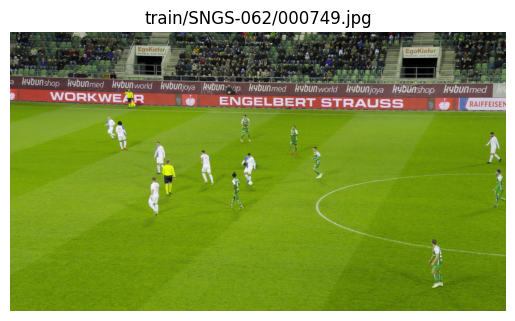

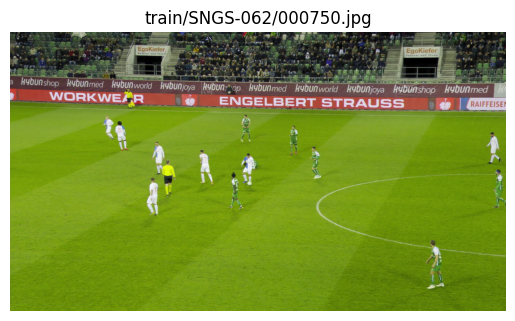

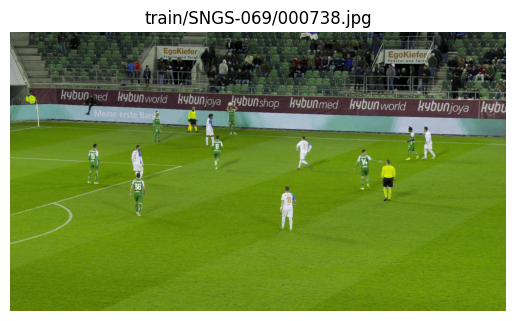

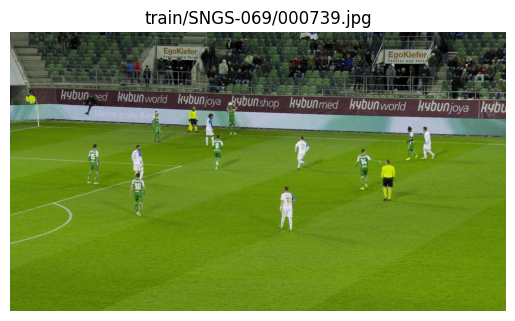

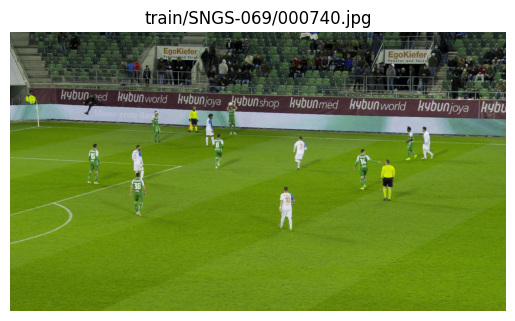

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

def show_frame(image_id):
    split_map = {"1": "train", "2": "valid"}
    split_digit = image_id[0]
    clip_id = image_id[1:4]
    frame_id = image_id[-3:]

    split = split_map.get(split_digit, "unknown")
    clip = f"SNGS-{clip_id.zfill(3)}"
    img_name = f"{frame_id.zfill(6)}.jpg"
    img_path = ROOT / split / clip / "img1" / img_name

    if not img_path.exists():
        print(f"❌ Image not found: {img_path}")
        return

    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"{split}/{clip}/{img_name}")
    plt.axis("off")
    plt.show()

# 🔍 Exemple : afficher les 5 premières frames non calibrables
for img_id in no_calib_frames["image_id"].head(5):
    show_frame(img_id)

<Axes: title={'center': 'Distribution du nombre de types de lignes visibles par frame'}, xlabel='n_lines_visible'>

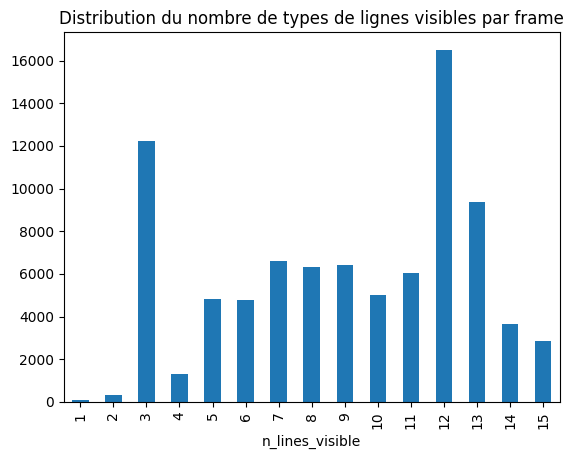

In [27]:

df["lines_visible"] = df["lines_visible"].apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else ())# Nombre de types de lignes visibles par frame (sans duplication)
lines_per_frame = df[["image_id", "n_lines_visible", "lines_visible"]].drop_duplicates()

# Distribution du nombre de lignes visibles
lines_per_frame["n_lines_visible"].value_counts().sort_index().plot.bar(
    title="Distribution of the number of visible line types per frame"
)



Types présents dans df['lines_visible'] :
lines_visible
<class 'tuple'>    1481667
Name: count, dtype: int64

Exemples non vides :
0    (Big rect. left bottom, Big rect. left main, B...
1    (Big rect. left bottom, Big rect. left main, B...
2    (Big rect. left bottom, Big rect. left main, B...
3    (Big rect. left bottom, Big rect. left main, B...
4    (Big rect. left bottom, Big rect. left main, B...
Name: lines_visible, dtype: object

1481667 frames avec une liste ou un tuple de lignes visibles.
Nombre total de lignes individuelles collectées : 13428979

Top lignes visibles les plus fréquentes :
Side line top             1370043
Circle central             833883
Big rect. right main       688985
Big rect. right top        679035
Big rect. left main        634242
Circle right               620744
Big rect. left top         620096
Middle line                618166
Side line right            591812
Circle left                552129
Side line bottom           545828
Side line left      

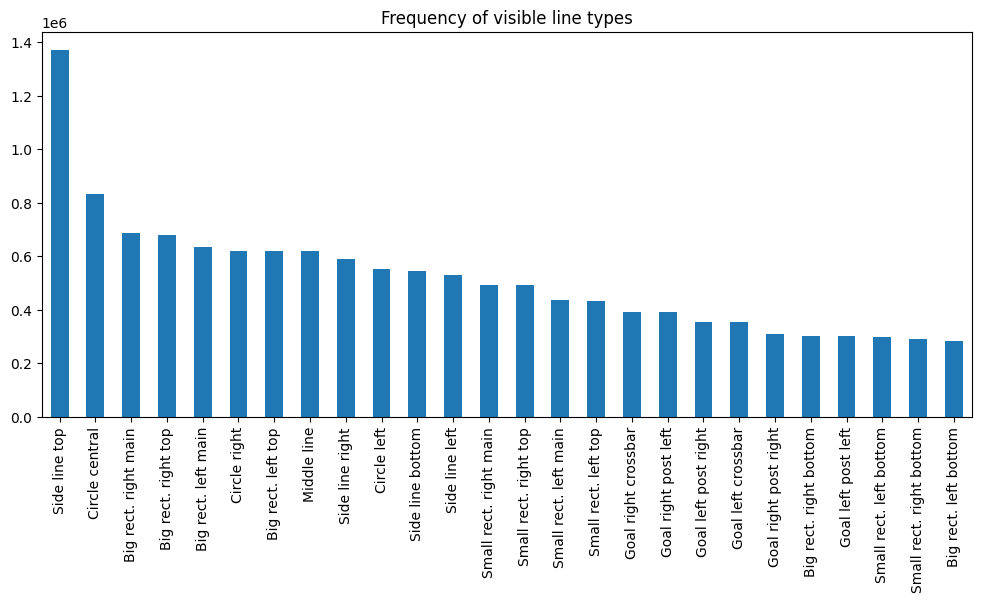

In [29]:
from collections import Counter
from itertools import chain
import pandas as pd

# Étape 1 : quels types réels dans lines_visible ?
print("Types présents dans df['lines_visible'] :")
print(df["lines_visible"].apply(type).value_counts())
print()

# Étape 2 : afficher un échantillon non vide pour visualiser ce qu'on manipule
print("Exemples non vides :")
print(df[df["lines_visible"].notna()]["lines_visible"].head(5))
print()

# Étape 3 : filtrer proprement les listes ou tuples
valid_lines = df["lines_visible"].dropna().apply(
    lambda x: x if isinstance(x, (list, tuple)) else []
)

print(f"{len(valid_lines)} frames avec une liste ou un tuple de lignes visibles.")

# Étape 4 : extraire toutes les lignes visibles
all_lines = list(chain.from_iterable(valid_lines))
print(f"Nombre total de lignes individuelles collectées : {len(all_lines)}")

# Étape 5 : compter les types de lignes
line_type_counts = Counter(all_lines)

# Étape 6 : transformer en série et afficher les 20 plus fréquents
line_freq = pd.Series(line_type_counts).astype(int).sort_values(ascending=False)
print("\nTop lignes visibles les plus fréquentes :")
print(line_freq.head(20))

# Étape 7 : tracer les graphiques uniquement si non vide
if not line_freq.empty:
    line_freq.head(10).plot.bar(title="Types de lignes visibles les plus fréquents")
    line_freq.plot.bar(figsize=(12, 5), title="Frequency of visible line types")
else:
    print("⚠️ Aucune ligne visible détectée dans le dataset.")



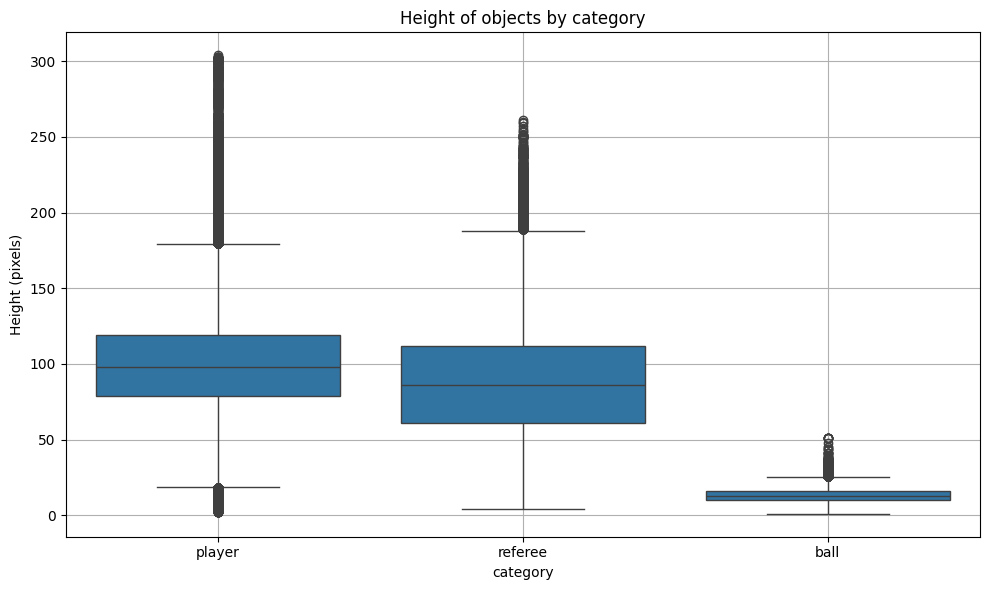

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Garder uniquement les objets avec bbox valides
df_bboxes = df.copy()
df_bboxes = df_bboxes[
    (df_bboxes["bbox_w"].notna()) &
    (df_bboxes["bbox_h"].notna())
]

# Convertir en float (au cas où)
df_bboxes["bbox_w"] = df_bboxes["bbox_w"].astype(float)
df_bboxes["bbox_h"] = df_bboxes["bbox_h"].astype(float)


# ➤ 3. Boxplot par catégorie
# On mappe les catégories en texte si tu veux
CATEGORY_MAP = {1: "player", 3: "referee", 4: "ball"}
df_bboxes["category"] = df_bboxes["category_id"].map(CATEGORY_MAP)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_bboxes, x="category", y="bbox_h")
plt.title("Height of objects by category")
plt.ylabel("Height (pixels)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
df[df["category_id"] == 2]["role"].value_counts()

role
goalkeeper    50127
Name: count, dtype: int64

        n_players  n_with_jersey  pct_with_jersey
count  115.000000     115.000000       115.000000
mean    21.269565      16.513043        77.966634
std      1.434669       2.947985        14.480252
min     14.000000       9.000000        39.285714
25%     21.000000      15.000000        69.090909
50%     21.000000      17.000000        80.952381
75%     22.000000      19.000000        90.476190
max     28.000000      20.000000        95.238095


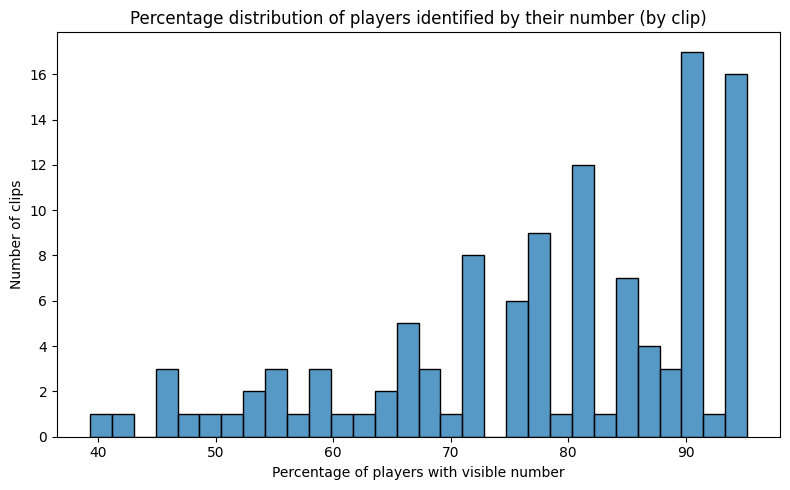

In [40]:
# Garder uniquement les objets player ou goalkeeper
df_players = df[df["category_id"].isin([1, 2])].copy()

# Vérifier la validité des track_id et jersey
df_players = df_players[df_players["track_id"].notna()]
df_players["has_jersey"] = df_players["jersey"].notna()

# Grouper par clip : nombre de joueurs uniques et nb avec jersey détecté
clip_stats = (
    df_players.groupby(["split", "clip", "track_id"])
    .agg(has_jersey=("has_jersey", "max"))  # au moins un jersey visible pour ce joueur
    .reset_index()
    .groupby(["split", "clip"])
    .agg(
        n_players=("track_id", "nunique"),
        n_with_jersey=("has_jersey", "sum")
    )
    .reset_index()
)

# Ajouter une colonne : pourcentage de joueurs identifiés par leur numéro
clip_stats["pct_with_jersey"] = 100 * clip_stats["n_with_jersey"] / clip_stats["n_players"]

# Afficher les stats globales
print(clip_stats.describe())

# Visualisation simple
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(clip_stats["pct_with_jersey"], bins=30, kde=False)
plt.title("Percentage distribution of players identified by their number (by clip)")
plt.xlabel("Percentage of players with visible number")
plt.ylabel("Number of clips")
plt.tight_layout()
plt.show()
